<a href="https://colab.research.google.com/github/jsong55/Machine_Learning/blob/master/AF_classification_using_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os
import random
import tensorflow as tf
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential, layers
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
import datetime
import tensorflow_hub as hub

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!wget https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
from TF_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, view_random_image

--2022-10-24 02:29:01--  https://raw.githubusercontent.com/jsong55/Machine_Learning/master/TF_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10747 (10K) [text/plain]
Saving to: ‘TF_functions.py’

TF_functions.py     100%[===================>]  10.50K  --.-KB/s    in 0s      

2022-10-24 02:29:01 (90.0 MB/s) - ‘TF_functions.py’ saved [10747/10747]



image shape: (150, 150, 3)


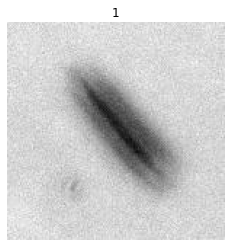

In [5]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/python_torturial/NW_image_quality_50tests_rgb_revserved.zip","r")
zip_ref.extractall()
zip_ref.close()

# Setup the train and test directories
train_dir = "NW_image_quality_50tests_rgb_revserved/train/"
test_dir = "NW_image_quality_50tests_rgb_revserved/test/"
# visualize
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
class_names

img = view_random_image(target_dir=train_dir,
              target_class=random.choice(class_names))

In [6]:
IMAGE_SIZE = (150,150)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                        image_size=IMAGE_SIZE,
                                        label_mode="categorical",
                                        batch_size=32,
                                        shuffle=True)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                  image_size=IMAGE_SIZE,
                                  label_mode="categorical",
                                  batch_size=32)

Found 2640 files belonging to 5 classes.
Found 1200 files belonging to 5 classes.


In [7]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.Rescaling(1./255) #need for resnet but not for efficientnet
],name="data_augmentation")

In [10]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.ResNet50(include_top=False)
# Check the layers in our base model
#for layer_number, layer in enumerate(base_model.layers):
#  print(layer_number, layer.name)

# The model contains a noramlization and rescaling layer

# 2. Free the base model (the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(150,150,3),name="input_layer")

# 4. If using a model like ResNet50V2, you will need to noramlize inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = data_augmentation(inputs)
# Give base model the inputs (after augmentation) and don't train it
x = base_model(x,training=False)

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(5,activation="softmax",name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
        optimizer = Adam(),
        metrics=["accuracy"])

# 10. Fit the model and save the history
history_0 = model_0.fit(train_data,
                  epochs=50,
                  steps_per_epoch=len(train_data),
                  validation_data=test_data,
                  validation_steps=int(0.25*len(test_data)),
                  callbacks=[create_tensorboard_callback(dir_name="ResNet50",
                                      experiment_name="ResNet_Test1")])

Shape after GlobalAveragePooling2D: (None, 2048)
Saving TensorBoard log files to: ResNet50/ResNet_Test1/20221024-023627
Epoch 1/50
83/83 [==============================] - 12s 106ms/step - loss: 1.5955 - accuracy: 0.2087 - val_loss: 1.6464 - val_accuracy: 0.1701
Epoch 2/50
83/83 [==============================] - 8s 94ms/step - loss: 1.5752 - accuracy: 0.2405 - val_loss: 1.6616 - val_accuracy: 0.2465
Epoch 3/50
83/83 [==============================] - 9s 107ms/step - loss: 1.5666 - accuracy: 0.2466 - val_loss: 1.6129 - val_accuracy: 0.1910
Epoch 4/50
83/83 [==============================] - 8s 95ms/step - loss: 1.5635 - accuracy: 0.2485 - val_loss: 1.6129 - val_accuracy: 0.2118
Epoch 5/50
83/83 [==============================] - 8s 94ms/step - loss: 1.5726 - accuracy: 0.2348 - val_loss: 1.6126 - val_accuracy: 0.3368
Epoch 6/50
83/83 [==============================] - 8s 96ms/step - loss: 1.5563 - accuracy: 0.2682 - val_loss: 1.5992 - val_accuracy: 0.2188
Epoch 7/50
83/83 [=============

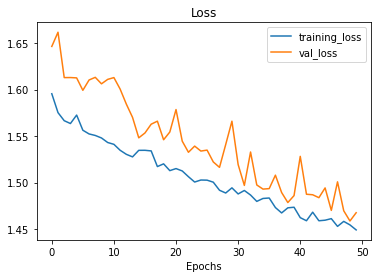

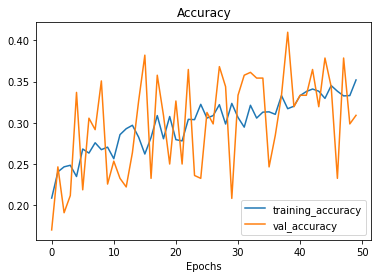

In [11]:
plot_loss_curves(history_0)

In [9]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn